In [1]:
version = 'ver2'

In [1]:
import docx 
from rouge import Rouge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import bert_score
import pandas as pd
from gensim.models import Word2Vec
from prompt_template import evaulate_keyword_prompt1, validate_response_prompt, generate_response
from library.exportation import export_evaluation_result
import openpyxl
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
key = "sk-NAWSSGI7999d18B51046T3BlBkFJ514d034054e342cc99c3"

c:\Python-3124\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_text_from_docx(docx_path):
    doc = docx.Document(docx_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

def compute_rouge(generated, ground_truth):
    rouge = Rouge()
    scores = rouge.get_scores(generated, ground_truth, avg=True)
    return scores

def compute_cosine_similarity(doc1, doc2):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([doc1, doc2])
    return cosine_similarity(vectors[0:1], vectors[1:2])[0][0]

def compute_bleu(generated, ground_truth):
    reference = [ground_truth.split()]
    candidate = generated.split()
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return score

def compute_bertscore(generated, ground_truth):
    P, R, F1 = bert_score.score([generated], [ground_truth], lang="en", verbose=True)
    return F1.mean().item()

def cust_cosine_similarity(expected_value, response):
    tokens1 = expected_value.lower().split()
    tokens2 = response.lower().split()

    # Create a Word2Vec model (for demonstration only; normally you'd load a pre-trained model)
    model = Word2Vec([tokens1, tokens2], min_count=1)

    # Get average vector for each sentence
    def average_vector(tokens):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0)

    vec1 = average_vector(tokens1)
    vec2 = average_vector(tokens2)

    # Calculate cosine similarity
    similarity = cosine_similarity([vec1], [vec2])
    return similarity[0][0]

# response and expected value evaluation

In [3]:
codes = ['1', '778', '916', '3306', '6055']

all_result = []

for code in codes:
    expected_value = pd.read_excel('expected_value.xlsx', sheet_name=code).iloc[:, -1].dropna()
    response = pd.read_excel('response.xlsx', sheet_name=code).iloc[:, -1].dropna()
    result = []
    for i, j in zip(expected_value, response):
        score = cust_cosine_similarity(i, j)
        result.append(score)
    
    result_df = pd.DataFrame(result, columns=['ver2'])

    all_result.append(result_df)

with pd.ExcelWriter('evaluation_response_score.xlsx') as writer:
    all_result[0].to_excel(writer, sheet_name='1', index=False)
    all_result[1].to_excel(writer, sheet_name='778', index=False)
    all_result[2].to_excel(writer, sheet_name='916', index=False)
    all_result[3].to_excel(writer, sheet_name='3306', index=False)
    all_result[4].to_excel(writer, sheet_name='6055', index=False)


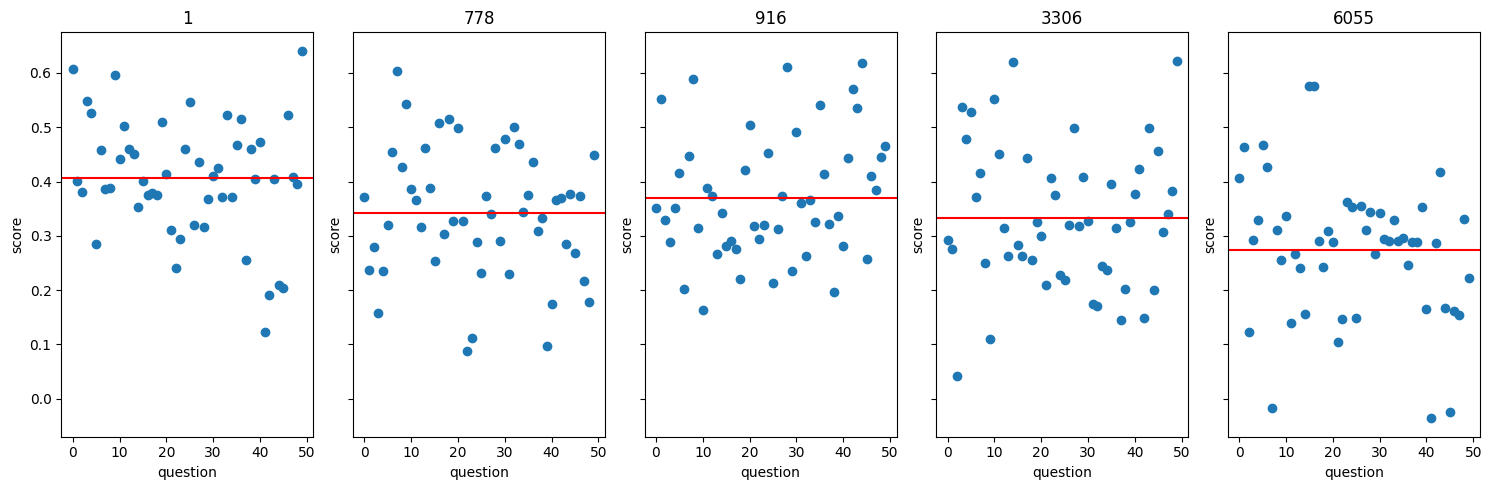

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(15, 5))

# Loop through the axes and plot the data
for i, (ax, result) in enumerate(zip(axes, all_result)):
    ax.scatter(result.index, result['ver2'])
    ax.axhline(y=result['ver2'].mean(), color='r', linestyle='-', label='Average')
    ax.set_title(f'{codes[i]}')
    ax.set_xlabel('question')
    ax.set_ylabel('score')

# Adjust layout
plt.tight_layout()
plt.show()

In [5]:
codes = ['1', '778', '916', '3306', '6055']

all_result_ai = []

for code in codes:
    question = pd.read_excel('questions.xlsx', sheet_name=code).iloc[:, -1].dropna()
    expected_value = pd.read_excel('expected_value.xlsx', sheet_name=code).iloc[:, -1].dropna()
    response = pd.read_excel('response.xlsx', sheet_name=code).iloc[:, -1].dropna()
    result = []
    for i, j, k in tqdm(zip(question, expected_value, response)):
        keyword_prompt = validate_response_prompt(i, j, k)
        score = generate_response(keyword_prompt, key)
        result.append(score)

        result_df = pd.DataFrame(result, columns=['ver2'])

    all_result_ai.append(result_df)

with pd.ExcelWriter('evaluation_response_by_ai.xlsx') as writer:
    all_result_ai[0].to_excel(writer, sheet_name='1', index=False)
    all_result_ai[1].to_excel(writer, sheet_name='778', index=False)
    all_result_ai[2].to_excel(writer, sheet_name='916', index=False)
    all_result_ai[3].to_excel(writer, sheet_name='3306', index=False)
    all_result_ai[4].to_excel(writer, sheet_name='6055', index=False)

50it [01:47,  2.14s/it]
50it [02:00,  2.41s/it]
50it [01:57,  2.34s/it]
50it [01:41,  2.03s/it]
50it [01:48,  2.18s/it]


In [6]:
# keyword_prompt = validate_response_prompt(keyword_916_str, generated_report)
result = generate_response(keyword_prompt, key)

In [10]:
print(result)

0  
A commitment to growth, innovation, and responding to market demands.


In [32]:
report_list = ['1.HK_2024113012.txt', 
               '778.HK_2024113012.txt',
               '916.HK_20241127_0013.txt',
               '3306.HK_2024113012.txt',
               '6055.HK_2024113012.txt']
ground_truth_list = ['1.HK.docx', '778.HK.docx', '916.HK.docx', '3306.HK.docx', '6055.HK.docx']

result_score = []
for ground_truth, report in zip(ground_truth_list, report_list):
    print(ground_truth, report)

    ground_truth_path = rf'4_ground_truth\{ground_truth}'
    generated_path = rf'{version}\2_report_log\{report}'

    generated_report = open(generated_path, "r", encoding="ISO-8859-1").read()
    ground_truth_report = extract_text_from_docx(ground_truth_path)
    bertscore = compute_bertscore(generated_report, ground_truth_report)
    result_score.append(bertscore)

1.HK.docx 1.HK_2024113012.txt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 64.06it/s]


done in 1.12 seconds, 0.90 sentences/sec
778.HK.docx 778.HK_2024113012.txt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 207.40it/s]


done in 1.13 seconds, 0.88 sentences/sec
916.HK.docx 916.HK_20241127_0013.txt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<?, ?it/s]


done in 1.10 seconds, 0.91 sentences/sec
3306.HK.docx 3306.HK_2024113012.txt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<?, ?it/s]


done in 1.19 seconds, 0.84 sentences/sec
6055.HK.docx 6055.HK_2024113012.txt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 335.46it/s]

done in 1.15 seconds, 0.87 sentences/sec


In [36]:
result_score

[0.7273915410041809,
 0.7235782146453857,
 0.7266682386398315,
 0.7223191857337952,
 0.7134838104248047]

In [20]:
rouge_score = compute_rouge(generated_report, ground_truth_report)
print(f"rouge score: {rouge_score}")

rouge score: {'rouge-1': {'r': 0.1565217391304348, 'p': 0.2819843342036554, 'f': 0.20130474843819632}, 'rouge-2': {'r': 0.03360116873630387, 'p': 0.06774668630338733, 'f': 0.044921870567555866}, 'rouge-l': {'r': 0.1463768115942029, 'p': 0.26370757180156656, 'f': 0.18825721814928673}}


In [21]:
similarity = compute_cosine_similarity(generated_report, ground_truth_report)
print(f"Cosine Similarity: {similarity}")

Cosine Similarity: 0.7128947745817923


In [22]:
bleu_score = compute_bleu(generated_report, ground_truth_report)
print(f"BLEU Score: {bleu_score}")

BLEU Score: 0.00815540344271176


In [56]:
bertscore = compute_bertscore(generated_report, ground_truth_report)
print(f"BERTScore: {bertscore}")

c:\Python-3124\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ansonfung4\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 73.59it/s]

done in 0.90 seconds, 1.12 sentences/sec
BERTScore: 0.7266682386398315
